# Mean square displacement for GSD file from hoomd

**Author**: _YeNguyenEdalgo_

**Function**
    1. Read a GSD file from HOOMD in Pure python reader
    2. Perform MSD calculation 

In [21]:
"""Specify name of the trajectory file"""

type = 'weakCoupling'

In [22]:
from math import *
import numpy as np 
from matplotlib import pyplot as plt 
import gsd 
import gsd.hoomd
import gsd.pygsd

**Parameters**

Parameter values are obtained from LAMMPS simulation of magnetic colloids by Faraudo_2011_SI

In [23]:
"""Reference value"""
mass            = 5.24e-19                                  #kg/particle
LJ_sigma        = 100                                       #nm 
LJ_epsilon      = 1.3e-20                                   #J or kg m2 s-2
time_scale      = LJ_sigma*(mass/LJ_epsilon)**(1/2)*1e-9    #sec
kB              = 1.38064852e-23                            #kg m2 s-2 K-1

"""Real Units"""
par_ls          = 20                   #particle  
box_length      = 9.3e3                 #nm
NP_diameter     = 100                  #nm
r_cut_LJ        = NP_diameter          #nm 
r_cut_dd        = 1000                 #nm 
time_step       = 1.01e-10              #s  
viscosity       = 8.5251e-4            #N m-2 s-1 #NIST at water density=1000g/L
damp            = mass / (3*pi * viscosity * NP_diameter*1e-9) #s
#damp            = 0.5545e-9            #s
#damp            = 55.6e-9              #s
T               = 300                  #K  
dipole_moment   = 1.44e-17             #J/T 
mag_const       = 4*pi*1e-7            #T m A-1 
sim_time        = 0.1                  #s  
log_period      = 0.51e-3              #s                   

"""Normalized"""
mass_r          = 1 
LJ_sigma_r      = 1 
LJ_epsilon_r    = 1 
box_length_r    = box_length / LJ_sigma 
NP_diameter_r   = NP_diameter / LJ_sigma 
r_cut_LJ_r      = r_cut_LJ / LJ_sigma
r_cut_dd_r      = r_cut_dd / LJ_sigma 
time_step_r     = time_step / time_scale
damp_r          = damp / time_scale
drag_coeff_r    = 0.0001 * mass_r / damp_r
T_r             = T * kB / LJ_epsilon
dipole_moment_r = dipole_moment / ((4*pi/mag_const*(LJ_sigma*1e-9)**3*LJ_epsilon)**(1/2))                              
sim_time_r      = sim_time / time_scale
log_period_r    = log_period / time_scale

print("mass: "+str(mass_r),
      "sigma: "+str(LJ_sigma_r),
      "epsilon: "+str(LJ_epsilon_r),
      "box_length: "+str(box_length_r), 
      "r_cut_LJ: "+str(r_cut_LJ_r), 
      "r_cut_dd: "+str(r_cut_dd_r), 
      "time_step: "+str(time_step_r), 
      "damp: "+str(damp)+ " s",
      "re-scale reduced drag: "+str(drag_coeff_r), 
      "Temp: "+str(T_r),
      "dipole_moment: "+str(dipole_moment_r),
      "sim_time: "+str(sim_time)+" sec",
      "log_period: "+str(sim_time/log_period)+" frames",
      sep="\n")

"""Concentration, volume fraction, and diffusion Check"""
sys_vol         = box_length**3*1e-24                       #liter
par_vol         = 4/3*pi*(NP_diameter/2)**3*1e-24           #liter
concentration   = mass*par_ls**3*1e3/sys_vol                #g/L
vol_fraction    = format(par_vol*par_ls**3/sys_vol, 'e')
diffusion_coeff = kB*T / (3*pi*viscosity*NP_diameter*1e-9) 
print("concentration is "+str(concentration)+" g/L")
print("volume fraction is "+str(vol_fraction))
print("D_theory is "+str(diffusion_coeff)+" m2/s")
print("corrected damp: "+str(damp)+" s")

mass: 1
sigma: 1
epsilon: 1
box_length: 93.0
r_cut_LJ: 1.0
r_cut_dd: 10.0
time_step: 0.00015908433118154948
damp: 6.521697902284872e-10 s
re-scale reduced drag: 0.09734940238013003
Temp: 0.3186111969230769
dipole_moment: 1.262963547802122
sim_time: 0.1 sec
log_period: 196.078431372549 frames
concentration is 5.211616235079696 g/L
volume fraction is 5.207626e-03
D_theory is 5.155060624051553e-12 m2/s
corrected damp: 6.521697902284872e-10 s


**Calculate msd**

\begin{equation}
    \langle r^2 \rangle = \langle x^2 \rangle + \langle y^2 \rangle + \langle z^2 \rangle
\end{equation}

\begin{equation}
    \langle x^2 \rangle= \frac{1}{N}\sum^N_{i=1}\big(x(t)-x(0)\big)^2
\end{equation}

\begin{equation}
    \langle y^2 \rangle= \frac{1}{N}\sum^N_{i=1}\big(y(t)-y(0)\big)^2
\end{equation}

\begin{equation}
    \langle z^2 \rangle= \frac{1}{N}\sum^N_{i=1}\big(z(t)-z(0)\big)^2
\end{equation}

where $\langle r^2 \rangle$ is the mean square displacement for a Brownian partilce in 3D; $x(t)$, $y(t)$, $z(t)$ are positions of each particle in the $xyz$ coordinates at time $t$, respectively; $N$ is the number of particles.

In [24]:
frame = gsd.pygsd.GSDFile(open('Data/trajectory_'+type+'.gsd', 'rb'))
#frame = gsd.pygsd.GSDFile(open('test.gsd','rb'))
traj_ls = gsd.hoomd.HOOMDTrajectory(frame)

msd = np.array([])
for i in range (len(traj_ls)):
    r_0 = np.array(traj_ls[0].particles.position)
    delta_r_sq = np.sum(np.average(np.square(traj_ls[i].particles.position-r_0), axis=0),axis=0)
    msd = np.reshape(np.append(msd, delta_r_sq),(i+1,1))

**Plot the results and calculate diffusion coefficient**

Diffusion coefficient obtained from the simulation trajectory ($D_{sim}$) is evaluated as:

\begin{equation}
     D_{sim} = \frac{\langle r^2 \rangle}{6t}
\end{equation}

$D_{sim}$ is compared with the diffusion coefficient obtained from theory $D_{theory}$ given as:

\begin{equation}
    D_{theory} = \frac{k_BT}{3\pi\eta d_p}
\label{D_theory}
\end{equation}

\begin{equation}
    \eta = \frac{m}{3\pi\tau d_p}
\label{Viscosity}
\end{equation}

where $k_B T$ is the Boltzmann temperature, $d_p$ is the diameter of the colloidal particle, $m$ is the mass of each particle, $\eta$ is the solvent viscosity and $\tau$ is the damping parameter. 

D_sim = 3.699649302164713e-12 m2/s


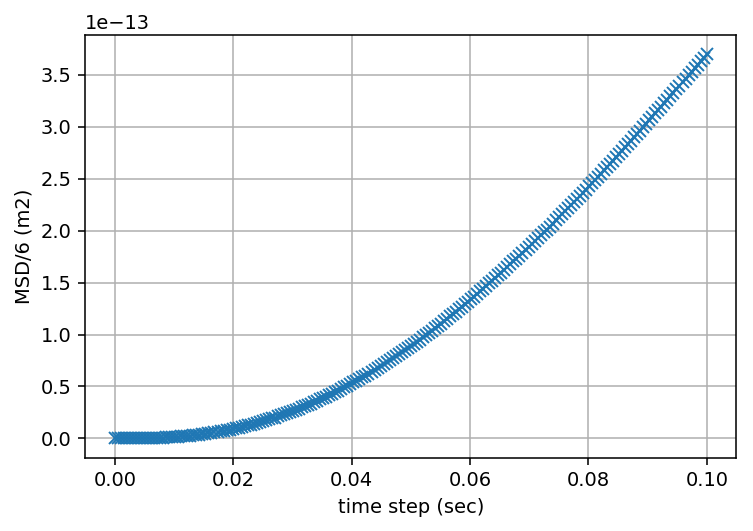

In [25]:
x = np.arange(0,sim_time,log_period) 
y = 1/6 * msd * (LJ_sigma*1e-9)**2

Dif_coef = 1/6 * msd[-1,0] * (LJ_sigma*1e-9)**2 / sim_time
print('D_sim = '+str(Dif_coef)+' m2/s')

plt.figure(figsize=None, dpi=140);
plt.plot(x, y, 'x');
plt.xlabel('time step (sec)');
plt.ylabel('MSD/6 (m2)')
#plt.ylabel('$\frac{\langle r^2 \rangle}{6}$ (m^2)');
plt.grid(True)
plt.savefig('Figures/msd_calc_'+type+'.pdf')